Projekt AIR - Recipe analysis

# 0) data loading, prepreation

In [ ]:
#mount google drive
# !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !sudo apt-get update -qq 2>&1 > /dev/null
# !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
# !google-drive-ocamlfuse

!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

/content
mkdir: cannot create directory ‘drive’: File exists
/content/drive
mkdir: cannot create directory ‘MyDrive’: File exists
/content
/
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [ ]:
# set rand seed
SEED = 12345678

In [ ]:
%pip install transformers
%pip install torcheval
# imports
from torch import nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import ast
import copy
import math

# load datasets
#recipes          = pd.read_csv('drive/MyDrive/kaggle_recipes/PP_recipes.csv')
raw_recipes      = pd.read_csv('/content/drive/MyDrive/kaggle_recipes/RAW_recipes.csv')
#ingredient_map   = pd.read_pickle('drive/MyDrive/kaggle_recipes/ingr_map.pkl')
raw_interactions = pd.read_csv('/content/drive/MyDrive/kaggle_recipes/RAW_interactions.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load interactions into recipes
recipe_interactions = pd.merge(raw_recipes, raw_interactions, left_on='id', right_on='recipe_id')
recipe_interactions.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...


# 1) meal planning / suggestion based on personal taste and diet preferences

# Basic data Analysis

**Rating distribution**

In [ ]:
recipe_interactions['rating'].describe()

count    1.132367e+06
mean     4.411016e+00
std      1.264752e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

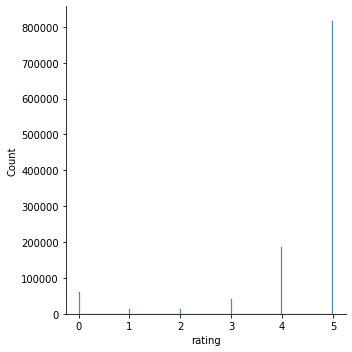

In [ ]:
sns.displot(recipe_interactions['rating'])

**Correlations**

In [ ]:
corr_data = recipe_interactions.drop(['user_id', 'id', 'contributor_id', 'recipe_id'], axis=1)
corr_data.head(2)
plt.figure(figsize=(20, 8))
sns.heatmap(corr_data.corr(), annot=True)

# -> minimal (no) correlation between minutes, steps and rating
# -> might be different for individual useres

NameError: ignored

In [ ]:
# correlations between nutriton data & rating
#corr_data['nutrition'] = corr_data['nutrition'].apply(ast.literal_eval)

def toFloat(row):
  row[0] = row[0].replace('[', '')
  row[-1] = row[-1].replace(']', '')
  for i, data in enumerate(row):
    row[i] = float(data)
  return row

# expand nutrition data, drop data from before
corr_data.head(2)
corr_data_nut = corr_data.drop(['n_steps', 'minutes', 'n_ingredients'], axis=1)
corr_data_nut[['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']] = [toFloat(row) for row in corr_data['nutrition'].str.split(",")]

plt.figure(figsize=(20, 8))
sns.heatmap(corr_data_nut.corr(), annot=True)

#-> no correlation between rating and individual ingredients
#-> might be different for individual users

NameError: ignored

**Train & predict tags for recipes, based on description (and nutrition distribution) - later used for recipe querying & recommendation, clustering recipes**

In [ ]:
# convert data types
data = copy.copy(raw_recipes)
data['tags'] = raw_recipes['tags'].apply(ast.literal_eval)
data['nutrition'] = raw_recipes['nutrition'].apply(ast.literal_eval)
data['ingredients'] = raw_recipes['ingredients'].apply(ast.literal_eval)

**Analyze word count of descriptions**


(array([5.8192e+04, 6.2163e+04, 4.3155e+04, 2.5456e+04, 1.4958e+04,
        8.6350e+03, 5.2350e+03, 3.0920e+03, 1.8970e+03, 1.1590e+03,
        8.7000e+02, 5.9000e+02, 3.7800e+02, 2.2300e+02, 1.7300e+02,
        1.0600e+02, 9.1000e+01, 5.9000e+01, 5.2000e+01, 3.6000e+01]),
 array([  1. ,  15.9,  30.8,  45.7,  60.6,  75.5,  90.4, 105.3, 120.2,
        135.1, 150. , 164.9, 179.8, 194.7, 209.6, 224.5, 239.4, 254.3,
        269.2, 284.1, 299. ]),
 <a list of 20 Patch objects>)

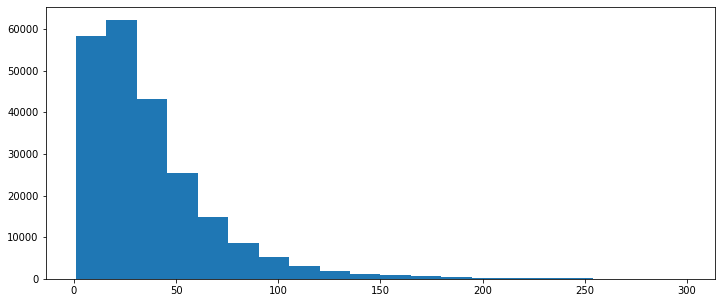

In [ ]:
def wordcount(description):
  return description.str.count(' ') +1

max_description_len = 300

data = data.assign(description_words = lambda row: wordcount(row['description']), axis=1)
tagged_data = data[data['description_words'] > 0]
tagged_data = tagged_data[tagged_data['description_words'] < max_description_len]

plt.figure(figsize=(12, 5))
plt.hist(bins=20, x=tagged_data['description_words'])

In [ ]:
tag_occurences = {}

# initialise tokenizer and model
model_name = 'sentence-transformers/all-MiniLM-L6-v2' # TODO: check
tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)

len_tags = 20
# get top len_tags tags
for taglist in data['tags']:
  for tag in taglist:
    if tag not in tag_occurences:
      tag_occurences[tag] = 1
    else:
      tag_occurences[tag] +=1

top_tags = dict(sorted(tag_occurences.items(), reverse=True, key=lambda d: d[1])[:len_tags])
tag_list = top_tags.keys()

NameError: ignored

In [ ]:
# one-hot encode tags
# todo: remove most 2 frequent tags, seem to appear in each recipe
tagged_data = tagged_data.assign(tag_vector = lambda x: [[words_row.count(word) for word in tag_list] for words_row in x['tags']])

NameError: ignored

In [ ]:
# rand seed
MAX_DATA_SIZE = 50000 #-> avoid running out of gpu memory
# split data
test_size = .1
validation_size = .2
x = tagged_data.head(MAX_DATA_SIZE)
y = tagged_data['tag_vector'].head(MAX_DATA_SIZE).values.tolist()
# split data into train + test
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=test_size, random_state=SEED,shuffle=True)
# split train into train + validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=validation_size, random_state=SEED,shuffle=True)

KeyError: ignored

In [ ]:
# tokenize descriptions
# create class that reads the text in for BERT
class TaggedRecipes (torch.utils.data.Dataset):
    def __init__(self, data, tags, tokenizer):
        self.tokenizer = tokenizer
        self.text = data['description'].values.tolist()
        self.labels = tags
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens = True,
            max_length = 300,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        # todo: add token type ids?
               
        return {
        'input_ids': input_ids,
        'attention_mask': attn_mask,
        'label':torch.tensor(self.labels[index],dtype= torch.float)}

**Fine Tune Bert Model**

In [ ]:
# build data loaders
# init data class
batch_size = 70 # TODO: check
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# train loader
train_recipe_data = TaggedRecipes(x_tr, y_tr, tokenizer=tokenizer)
train_loader = DataLoader(train_recipe_data, batch_size, num_workers=12)
# test loader
test_recipe_data = TaggedRecipes(x_test, y_test, tokenizer=tokenizer)
test_loader = DataLoader(test_recipe_data, batch_size, num_workers=12)
# validation loader
validate_recipe_data = TaggedRecipes(x_val, y_val, tokenizer=tokenizer)
validate_loader = DataLoader(validate_recipe_data, batch_size, num_workers=12)

NameError: ignored

In [ ]:
# add classification layer
# train model on recipe descriptions
%pip install torcheval
from torcheval.metrics.functional import binary_f1_score

# Base bert model: 768 long vectors per token
# only 20 tags: add linear layer with 20 ouputs
%pip install pytorch_lightning

import pytorch_lightning as pl
import torch.nn.functional as F
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-cased", return_dict=True)

# recommended by pytorch: bcewithlogitsloss & sigmoid layer
class TagClassifier(pl.LightningModule): # TODO: rewrite as nn.module or include 
# explaination why LightningModule was used and what it implements for us 
# https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html
  # Setup
  def __init__(self,n_classes=len_tags,steps_per_epoch=None,n_epochs=3, lr=2e-5, 
               optimizer=torch.optim.Adam):
    super().__init__()
    self.classifier=nn.Linear(bert_model.config.hidden_size,
n_classes) 
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.lr = lr
    self.criterion = nn.BCEWithLogitsLoss()
    self.optimizer = optimizer
    self.model = bert_model
    self.loss = nn.CrossEntropyLoss()
    self._name = "TagClassifier"
    # todo: store this data on checkpoints
    self._epoch = 0
    self.epoch_losses = [[]] # 2d dict of losses per epoch
    self._val_epoch = 0
    self.epoch_losses_validation = [[]]
    self.f1_scores_validation = [[]]
    self.f1_scores = [[]]

  def forward(self, input_ids, attn_mask):
      # eval bert layers
      output_bert = self.model(input_ids=input_ids,attention_mask=attn_mask)
      # Extract the last hidden state of the token `[CLS]` for classification task
      last_hidden_state_cls = output_bert[0][:, 0, :] # todo: check
      # eval calssifier layer on top
      output = self.classifier(last_hidden_state_cls)
      return output
            
  def training_step(self, batch, batch_idx):
      labels = batch["label"]
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      # forward pass
      logits = self(input_ids, attention_mask)
      # compute loss
      loss = self.loss(logits, labels)
      # calc f1 score
      f1_score = binary_f1_score(torch.flatten(logits), torch.flatten(labels), threshold = 0.5)
      self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      self.log(f"train_f1", f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      # store loss/f1 scores
      self.epoch_losses[self._epoch].append(loss)
      self.f1_scores[self._epoch].append(f1_score)

      tqdm_dict = {f"train_loss": loss}
      output = dict({
          "loss": loss,
          "progress_bar": tqdm_dict,
          "log": tqdm_dict,
          "f1" : f1_score
          })
      return output

  def on_train_epoch_end(self):
    epoch_loss = 0
    epoch_f1_score = 0
    # avg loss of epoch
    for loss in self.epoch_losses[self._epoch]:
      epoch_loss += loss
    epoch_loss /= len(self.epoch_losses[self._epoch])

    # avg f1 score of epoch
    for f1_score in self.f1_scores[self._epoch]:
      epoch_f1_score += f1_score
    epoch_f1_score /= len(self.f1_scores[self._epoch])

    # log loss & f1
    print(f"Train Epoch: {self._epoch}, Loss: {epoch_loss.item()}, F1-Score: {epoch_f1_score.item()}")
    self._epoch += 1
    self.epoch_losses.append([])
    self.f1_scores.append([])

  def validation_step(self, batch, batch_idx):
      labels = batch["label"]
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      # forward pass
      logits = self(input_ids, attention_mask)
      # compute loss
      loss = self.loss(logits, labels)
      # calc f1 score
      f1_score = binary_f1_score(torch.flatten(logits), torch.flatten(labels), threshold = 0.5)
      # log
      self.log(f"validation_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      self.log(f"validation_f1", f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      # store loss/f1 scores
      self.epoch_losses_validation[self._val_epoch].append(loss)
      self.f1_scores_validation[self._val_epoch].append(f1_score)

      tqdm_dict = {f"validation_loss": loss}
      output = dict({
          "loss": loss,
          "progress_bar": tqdm_dict,
          "log": tqdm_dict,
          "f1" : f1_score
          })
      return output

  def on_validation_epoch_end(self):
    epoch_loss = 0
    epoch_f1_score = 0
    # avg loss of epoch
    for loss in self.epoch_losses_validation[self._val_epoch]:
      epoch_loss += loss
    epoch_loss /= len(self.epoch_losses_validation[self._val_epoch])

    # avg f1 score of epoch
    for f1_score in self.f1_scores_validation[self._val_epoch]:
      epoch_f1_score += f1_score
    # DEBUG - TODO: REMOVE
    print(f"{self._val_epoch=}")
    print(f"{self.f1_scores=}")
    epoch_f1_score /= len(self.f1_scores_validation[self._val_epoch])

    # log loss & f1
    print(f"Validation Epoch: {self._val_epoch}, Loss: {epoch_loss.item()}, F1-Score: {epoch_f1_score.item()}")
    self._val_epoch += 1
    self.epoch_losses_validation.append([])
    self.f1_scores_validation.append([])

  def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 41.9 MB/s eta 0:00:00


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Train the model**

In [ ]:
# Initialize hyper parameters
epochs = 20
#batch_size = 1024
max_len = 300
learning_rate = 2e-05

def callback(): # TODO implement
  pass

# Instantiate the Model Trainer
# setup data module (used in fit method of pl)
class TagsDataModule(pl.LightningDataModule):
  def __init__(self, train_dataloader, test_dataloader, validation_dataloader):
    self.train_loader = train_dataloader
    self.test_loader = test_dataloader
    self.val_loader = validation_dataloader
    self.prepare_data_per_node = False # todo: check if can be enabled
    self._log_hyperparams = True
    self.save_dir = "/content/drive/MyDrive"
  # methods expected to be implementedd by pl.datamodule
  def train_dataloader(self):
    return self.train_loader
  def test_dataloader(self):
    return self.test_loader
  def val_dataloader(self):
    return self.val_loader

tags_data_module = TagsDataModule(train_loader, test_loader, validate_loader)

print(len(train_recipe_data))

trainer = pl.Trainer(max_epochs = epochs, accelerator = "gpu", gpus = [0])#, callbacks=[callback]) # gpus = x, if gpu available
model = TagClassifier(len_tags, None, epochs, learning_rate)
# Train the Classifier Model
#trainer.fit(model, train_dataloaders=tags_data_module)

36000


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


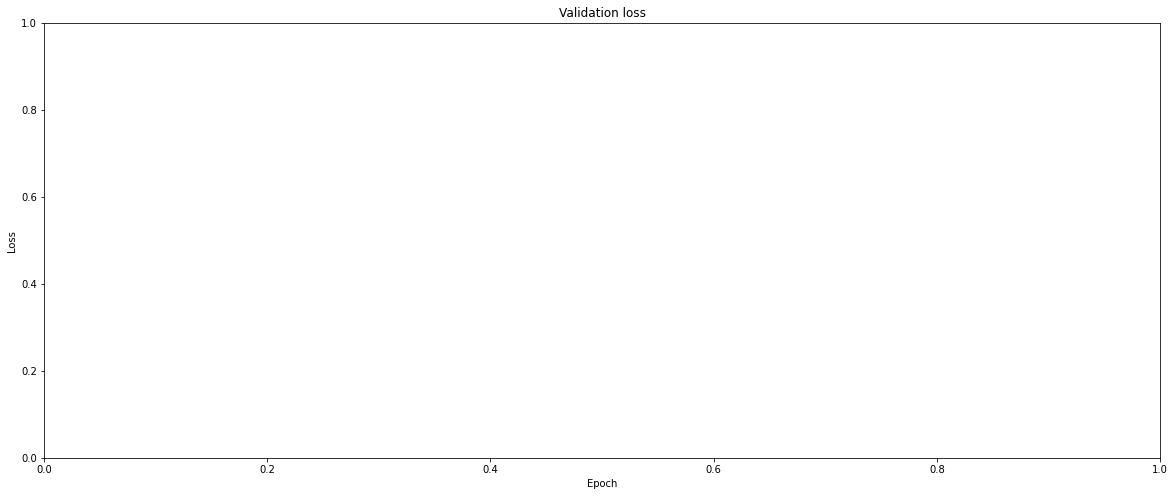

In [ ]:
# print & plot epoch validation losses
def average_loss(tensor_list):
  total_loss = 0
  for tensor in tensor_list:
    total_loss += tensor.item()
  return total_loss / len(tensor_list)
epoch_losses = [average_loss(x) for x in model.epoch_losses_validation if len(x) > 0]

plt.figure(figsize=(20, 8))
fig = sns.lineplot(data = epoch_losses).set(title="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show(fig)

# batch size = 70
# -> 50/70 top 20 label predictions completly correct at epoch 50

In [ ]:
# print & plot epoch validation f1-scores
epoch_losses = [average_loss(x) for x in model.f1_scores_validation if len(x) > 0]

plt.figure(figsize=(20, 8))
fig = sns.lineplot(data = epoch_losses).set(title="Validation f1 score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.show(fig)

**Create a combined network of the fine tuned bert model and (a fully connnected network) the nutritional values + as additional input. (compare against only nutritional, ingerdients as additional input, ingredients only)**

In [ ]:
# debugging cell 
#tagged_data.head(2)
batch_size_combined = 60 # TODO: check (~ 1000 should be possible)
#model = model.load_from_checkpoint("/lightning_logs/version_3/checkpoints/epoch=10-step=5665.ckpt")
#model.eval()
# create additional train test split

In [ ]:
# fine tuned bert model with classifier
bert_label_classifier = model

class TagClassifierCombined(pl.LightningModule):
  def __init__(self,n_classes=len_tags,steps_per_epoch=None,n_epochs=3, lr=2e-5, 
               optimizer=torch.optim.Adam):
    super().__init__()
    # 27 -> output bert classifier = 20, output nutrition network = 7
    self.classifier=nn.Linear(27,n_classes) 
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = n_epochs
    self.lr = lr
    self.criterion = nn.BCEWithLogitsLoss()
    self.optimizer = optimizer
    self.model = bert_label_classifier
    self.loss = nn.CrossEntropyLoss()
    self._name = "CombinedTagClassifier"
    # todo: store this data on checkpoints
    self._epoch = 0
    self.epoch_losses = [[]] # 2d dict of losses per epoch
    self._val_epoch = 0
    self.epoch_losses_validation = [[]]
    self.f1_scores_validation = [[]]
    self.f1_scores = [[]]
    # fully connected nutrition layer
    self.nutrition_network = nn.Sequential(
      nn.Linear(7, batch_size_combined),  # 7 nutrition values per recipe, batch_size = 70 (earlier defined)
      nn.ReLU(),  # non linear function between linear layers
      nn.Linear(batch_size_combined, 7),
      nn.Sigmoid()
      #nn.Linear(batch_size_combined, 7),  # one fully connected layer with ReLU activiation function
      #nn.ReLU(),  
      #nn.Linear(32, batch_size) # TODO: find fitting output size
    )

  def forward(self, input_ids, attn_mask, nutrition):
      # get label prediction from description text (top 20 labels)
      output_bert = self.model(input_ids=input_ids,attn_mask=attn_mask)
      # output = 20*batch_size x1 tensor
      # concat with nutrition network
      output_nutrition = self.nutrition_network((nutrition))
      # concat 20*batch_size x1 output_bert with 7*batch_size x1 output_nutrition
      tensor = torch.cat((output_bert,output_nutrition),1) # creates a 60x27 tensor
      # classify
      logits = self.classifier(tensor)
      return logits

  def predict_step(self, batch, batch_idx):
      labels = batch["label"]
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      nutrition = batch["nutrition"]
      # forward pass
      logits = self(input_ids, attention_mask, nutrition)
      return logits

  def training_step(self, batch, batch_idx):
      labels = batch["label"]
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      nutrition = batch["nutrition"]
      # forward pass
      logits = self(input_ids, attention_mask, nutrition)
      # compute loss
      loss = self.loss(logits, labels)
      # calc f1 score
      f1_score = binary_f1_score(torch.flatten(logits), torch.flatten(labels), threshold = 0.5)
      self.log(f"train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      self.log(f"train_f1", f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      # store loss/f1 scores
      self.epoch_losses[self._epoch].append(loss)
      self.f1_scores[self._epoch].append(f1_score)

      tqdm_dict = {f"train_loss": loss}
      output = dict({
          "loss": loss,
          "progress_bar": tqdm_dict,
          "log": tqdm_dict,
          "f1" : f1_score
          })
      return output

  def on_train_epoch_end(self):
    epoch_loss = 0
    epoch_f1_score = 0

    # avg loss of epoch
    for loss in self.epoch_losses[self._epoch]:
      epoch_loss += loss
    epoch_loss /= len(self.epoch_losses[self._epoch])

    # avg f1 score of epoch
    for f1_score in self.f1_scores[self._epoch]:
      epoch_f1_score += f1_score
    epoch_f1_score /= len(self.f1_scores[self._epoch])

    # log loss & f1
    print(f"Train Epoch: {self._epoch}, Loss: {epoch_loss.item()}, F1-Score: {epoch_f1_score.item()}")
    self._epoch += 1
    self.epoch_losses.append([])
    self.f1_scores.append([])

  def validation_step(self, batch, batch_idx):
      labels = batch["label"]
      input_ids = batch["input_ids"]
      attention_mask = batch["attention_mask"]
      nutrition = batch["nutrition"]
      # forward pass
      logits = self(input_ids, attention_mask, nutrition)
      # compute loss
      loss = self.loss(logits, labels)
      # calc f1 score
      f1_score = binary_f1_score(torch.flatten(logits), torch.flatten(labels), threshold = 0.5)
      # log
      self.log(f"validation_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      self.log(f"validation_f1", f1_score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
      # store loss/f1 scores
      self.epoch_losses_validation[self._val_epoch].append(loss)
      self.f1_scores_validation[self._val_epoch].append(f1_score)

      tqdm_dict = {f"validation_loss": loss}
      output = dict({
          "loss": loss,
          "progress_bar": tqdm_dict,
          "log": tqdm_dict,
          "f1" : f1_score
          })
      return output

  def on_validation_epoch_end(self):
    epoch_loss = 0
    epoch_f1_score = 0
    # avg loss of epoch
    for loss in self.epoch_losses_validation[self._val_epoch]:
      epoch_loss += loss
    epoch_loss /= len(self.epoch_losses_validation[self._val_epoch])
    # avg f1 score of epoch
    for f1_score in self.f1_scores_validation[self._val_epoch]:
      epoch_f1_score += f1_score
    epoch_f1_score /= len(self.f1_scores_validation[self._val_epoch])

    # log loss & f1
    print(f"Validation Epoch: {self._val_epoch}, Loss: {epoch_loss.item()}, F1-Score: {epoch_f1_score.item()}")
    self._val_epoch += 1
    self.epoch_losses_validation.append([])
    self.f1_scores_validation.append([])

  def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)


In [ ]:
class CombinedTaggedRecipes (torch.utils.data.Dataset):
    def __init__(self, input, tags, tokenizer):
        self.text = input['description'].values.tolist()
        self.nutrition = input['nutrition'].values.tolist()
        self.labels = tags
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
      text = self.text[index]
      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens = True,
          max_length = 300,
          padding = 'max_length',
          return_token_type_ids= False,
          return_attention_mask= True,
          truncation=True,
          return_tensors = 'pt'
        )
      input_ids = inputs['input_ids'].flatten()
      attn_mask = inputs['attention_mask'].flatten()             
      return {
        'input_ids': input_ids,
        'attention_mask': attn_mask,
        'nutrition': torch.tensor(self.nutrition[index], dtype=torch.float),
        'label':torch.tensor(self.labels[index], dtype=torch.float)
      }

# build data loaders
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# train loader
train_recipe_data_combined = CombinedTaggedRecipes(x_tr, y_train, tokenizer)
train_loader_combined = DataLoader(train_recipe_data_combined, batch_size_combined, num_workers=12)
# test loader
test_recipe_data_combined = CombinedTaggedRecipes(x_test, y_test, tokenizer)
test_loader_combined = DataLoader(test_recipe_data_combined, batch_size_combined, num_workers=12)
# validation loader
validate_recipe_data_combined = CombinedTaggedRecipes(x_val, y_val, tokenizer)
validate_loader_combined = DataLoader(validate_recipe_data_combined, batch_size_combined, num_workers=12)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Train the combined model**

In [ ]:
# Initialize hyper parameters
epochs = 20
#batch_size = 1024
learning_rate = 2e-05

def callback(): # TODO implement
  pass

# Instantiate the Model Trainer
combined_data_module = TagsDataModule(train_loader_combined, test_loader_combined, validate_loader_combined)

trainer = pl.Trainer(max_epochs = epochs, accelerator = "gpu", gpus = [0])#, callbacks=[callback]) # gpus = x, if gpu available
model_combined = TagClassifierCombined(len_tags, None, epochs, learning_rate)
# Train the Classifier Model
trainer.fit(model_combined, train_dataloaders=combined_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type              | Params
--------------------------------------------------------
0 | classifier        | Linear            | 560   
1 | criterion         | BCEWithLogitsLoss | 0     
2 | model             | TagClassifier     | 108 M 
3 | loss              | CrossEntropyLoss  | 0     
4 | nutrition_network | Sequential        | 907   
--------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.308   Total estimated model params size 

Sanity Checking: 0it [00:00, ?it/s]

Validation Epoch: 0, Loss: 235.64675903320312


Training: 0it [00:00, ?it/s]

OutOfMemoryError: ignored

**Plot of the loss per epoch**

In [ ]:
epoch_losses = [average_loss(x) for x in model_combined.epoch_losses_validation if len(x) > 0]

plt.figure(figsize=(20, 8))
fig = sns.lineplot(data = epoch_losses).set(title="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show(fig)

In [ ]:
# for later comparison: recommendation based on cosine-similarity of nutrition
def similar_recipes_nutrition(recipe_id):
  recipe_nutrition = data.loc[data['id'] == recipe_id]['nutrition'].values[0]
  # TODO: filter out same recipe id
  cosine_sim = [(row, np.dot(recipe_nutrition, nutrition) / (norm(recipe_nutrition)*norm(nutrition))) for row, nutrition in (zip(data['id'], data['nutrition']))]
  ordered_cosine_similarites = sorted(cosine_sim, reverse=True, key=lambda d: d[1])
  return ordered_cosine_similarites

similar = similar_recipes_nutrition(31490) # a different breakfast pizza
print(similar[0:5])

**Train a model with input data = user_id, nutrition, rating and compare the recommendations (precision, recall) to pure nutrition similarity**

In [ ]:
# Plot number of ratings per user
#rating_data.groupby(['user_id']).size().plot(kind = "bar")

In [ ]:
# split into training and test data, make sure that for each user 70% = train, 30% = test to represent each user.
rating_data = pd.merge(raw_recipes, raw_interactions, left_on='id', right_on='recipe_id')
train_split = 0.7

train_data = []
test_data  = []
users_min = 0

min_ratings = 6
# TODO: add max ratings per user?
grouped = rating_data.groupby('user_id')
for name, group in grouped:
    #print('ID: ' + str(name))
    ratings_by_user = group.shape[0]
    # skip users with < min_ratings
    if ratings_by_user < min_ratings:
      continue
    users_min +=1
    train_ratings = math.floor(train_split * ratings_by_user)
    test_ratings = ratings_by_user - train_ratings
    train = group.head(train_ratings)[['user_id', 'nutrition', 'rating']].values.tolist()
    test = group.tail(test_ratings)[['user_id', 'nutrition', 'rating']].values.tolist()
    train_data.extend(train)
    test_data.extend(test)

print(len(test_data))
print(len(train_data))
print(users_min)
# TODO: model user based on nutrition priorities

# 1.1): Generate ingredient and recipe embeddings

**Step 1 - Create a dict of all words (each useed ingredient) and one-hot-encodings**

In [ ]:
tags_diet = ['low-sodium', 'low-carb', 'healthy', 'low-cholesterol', 'low-calorie']
tags_occasion = ['dinner-party', 'holiday-event', 'lunch', 'weeknight', 'brunch']
tags_time = ['60-minutes-or-less',
             '30-minutes-or-less',
             '4-hours-or-less',
             '3-steps-or-less',
             '15-minutes-or-less']
tags_country = ['north-american', 'american', 'european', 'asian', 'italian']
tags_dish_kind = ['desserts', 'pasta-rice-and-grains', 'side-dishes', 'appetizers',
                  'pasta', 'cookies-and-brownies', 'soups-stews', 'beverages', 'cakes']

data = data.assign(tags_diet =       lambda x: [[words_row.count(word) for word in tags_diet] for words_row in x['tags']], axis=1)
data['tags_diet'] = data['tags_diet'].apply(lambda x: np.array(x, dtype='f'))
data = data.assign(tags_occasion =   lambda x: [[words_row.count(word) for word in tags_occasion] for words_row in x['tags']], axis=1)       
data['tags_occasion'] = data['tags_occasion'].apply(lambda x: np.array(x, dtype='f'))
data = data.assign(tags_time =       lambda x: [[words_row.count(word) for word in tags_time] for words_row in x['tags']], axis=1)       
data['tags_time'] = data['tags_time'].apply(lambda x: np.array(x, dtype='f'))
data = data.assign(tags_country =    lambda x: [[words_row.count(word) for word in tags_country] for words_row in x['tags']], axis=1)       
data['tags_country'] = data['tags_country'].apply(lambda x: np.array(x, dtype='f'))
data = data.assign(tags_dish_kind =  lambda x: [[words_row.count(word) for word in tags_dish_kind] for words_row in x['tags']], axis=1)
data['tags_dish_kind'] = data['tags_dish_kind'].apply(lambda x: np.array(x, dtype='f'))


In [ ]:
# sanity check
data[['tags_diet']].values[0]

array([array([0, 0, 0, 0, 0])], dtype=object)

**Step 2 - Create groups of tags for later multi target learning**

In [ ]:
# dict of all unique ingredients
dictionary = dict()

# create lookup dict
i = 0
for ingredientlist in data['ingredients']:
  for ingredient in ingredientlist:
    if ingredient not in dictionary:
      dictionary[ingredient] = 1
    else:
      dictionary[ingredient] += 1

{'salt': 85746, 'butter': 54975, 'sugar': 44535, 'onion': 39065, 'water': 34914, 'eggs': 33761, 'olive oil': 32822, 'flour': 26266, 'milk': 25786, 'garlic cloves': 25748, 'pepper': 22319, 'brown sugar': 18655, 'garlic': 18087, 'all-purpose flour': 17659, 'baking powder': 17504, 'egg': 17304, 'salt and pepper': 15415, 'parmesan cheese': 14807, 'lemon juice': 14233, 'baking soda': 14099, 'vegetable oil': 13912, 'vanilla': 13315, 'black pepper': 13098, 'cinnamon': 12560, 'tomatoes': 11950, 'sour cream': 11779, 'garlic powder': 10887, 'vanilla extract': 10271, 'oil': 9925, 'honey': 9898, 'onions': 9872, 'cream cheese': 9827, 'garlic clove': 9779, 'celery': 9541, 'cheddar cheese': 8969, 'unsalted butter': 8935, 'soy sauce': 8856, 'mayonnaise': 8736, 'paprika': 7982, 'chicken broth': 7963, 'worcestershire sauce': 7832, 'extra virgin olive oil': 7704, 'fresh parsley': 7656, 'cornstarch': 7486, 'fresh ground black pepper': 7160, 'carrots': 7023, 'parsley': 7001, 'chili powder': 6984, 'bacon': 

<BarContainer object of 200 artists>

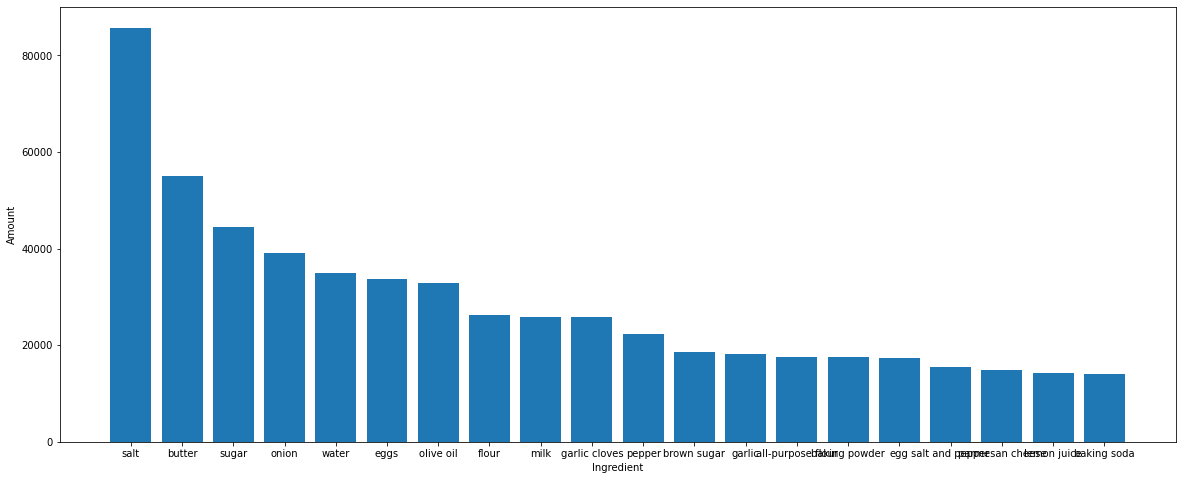

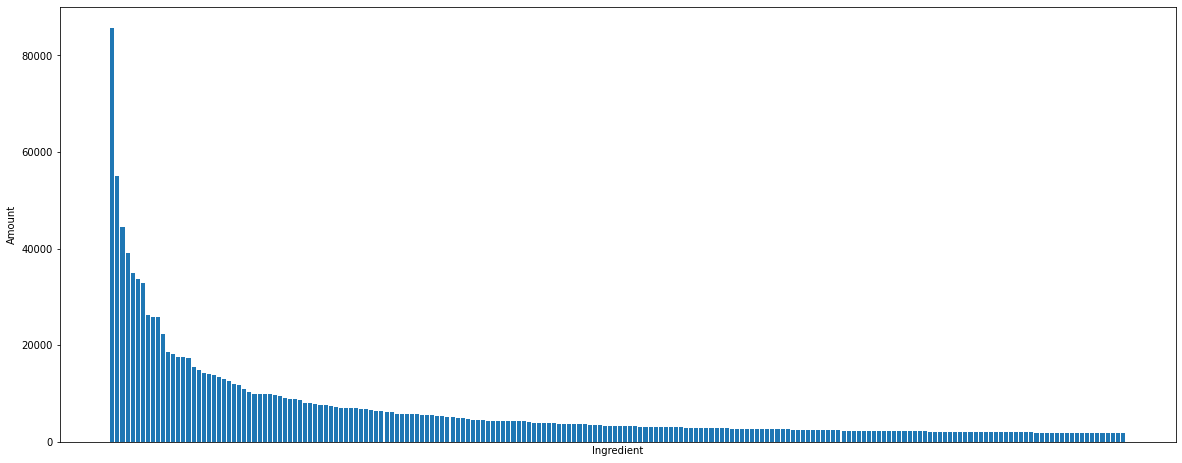

In [ ]:
ordered_ingredients = dict(sorted(dictionary.items(), reverse=True, key=lambda d: d[1])[:200])
print(ordered_ingredients)
keys = list(ordered_ingredients.keys())[:20]
vals = list(ordered_ingredients.values())[:20]

plt.figure(figsize=(20, 8))
plt.xlabel("Ingredient")
plt.ylabel("Amount")
plt.bar(keys, vals)

keys = list(ordered_ingredients.keys())
vals = list(ordered_ingredients.values())
plt.figure(figsize=(20, 8))
plt.xlabel("Ingredient")
plt.ylabel("Amount")
plt.xticks([])
plt.bar(keys, vals)

In [ ]:
# create column with filtered ingredients (in top 200)
def ingredientFilter(ingredients):
  table = []
  for row in ingredients:
    data = [ingredient for ingredient in row if ingredient in ordered_ingredients]
    table.append(data)
  return table

def ingredientCount(ingredients):
  table = []
  for row in ingredients:
    table.append(len(row))
  return table

data = data.assign(filtered_ingredients = lambda row: ingredientFilter(row['ingredients']), axis=1)
data = data.assign(num_ingredients = lambda row: ingredientCount(row['filtered_ingredients']), axis=1)
# filter recipes with less than 5 ingredients
min_ingredients = 5
filtered_recipes = data[data['num_ingredients'] > min_ingredients]

In [ ]:
len(filtered_recipes) # 198k
filtered_recipes['num_ingredients'].head(30)

2      8
3      7
7     12
9      7
12    10
19     8
21     7
22     9
23    13
26     9
27     7
29    13
30     7
31     7
33     6
41    16
42    12
44    10
47     9
48     7
49     7
50    15
51     9
55     8
56     7
57    13
59     6
62     7
64     9
66     7
Name: num_ingredients, dtype: int64

In [ ]:
# dict of all unique ingredients
dictionary = dict()
# create lookup dict
i = 0
for ingredientlist in filtered_recipes['filtered_ingredients']:
  for ingredient in ingredientlist:
    if ingredient not in dictionary:
      dictionary[ingredient] = i
      i += 1

# create a one-hot-encoded vector for each word (ingredient)
one_hot_encodings = dict()
total_words = len(dictionary)
for word, index in dictionary.items():
  word_vec = [0 for i in range(total_words)]
  word_vec[index] = 1
  one_hot_encodings[index] = np.array(word_vec)

# prepare data with sliding window size = 5 (todo: check vs 10)
def prepare_data(corpus, n_gram = 2):
  token_targets = []
  for index, sentence in enumerate(corpus):
    row = filtered_recipes.iloc[index]
    diet = row['tags_diet']
    occasion = row['tags_occasion']
    country = row['tags_country']
    time = row['tags_time']
    dish = row['tags_dish_kind']
    for i in range(len(sentence)): # for each word
      # sliding window
      for w in range(-n_gram,n_gram+1):
          if i+w < 0 or i+w >= len(sentence): # border check
              continue
          if w == 0: # ignore self
              continue
          # convert to position in dict
          target_pos = dictionary[sentence[i]]
          neighbor_pos = dictionary[sentence[i+w]]
          # convert to one-hot encoding
          target_hot = one_hot_encodings[target_pos]
          neighbor_hot = one_hot_encodings[neighbor_pos]
          token_targets.append((target_hot, neighbor_hot, diet, occasion, country, time, dish))
  return token_targets

token_targets = prepare_data(filtered_recipes['filtered_ingredients'])

In [ ]:
# TODO: CHECK batch size (might run out of gpu mem)
BATCH_SIZE = 15

# split into train/test sets
test_size = .1
x_train,x_test,_,_ = train_test_split(token_targets, token_targets, test_size=test_size, random_state=SEED,shuffle=True)

# sanity check
print(x_train[0])

print(f"{len(x_train)=}")
print(f"{len(x_test)=}")

# lack of training time - reduce data size by factor 25
x_train = x_train[:math.floor(len(x_train) / 100)]
x_test = x_test[:math.floor(len(x_test) / 100)]

# make data a multiple of batch size
x_allign_train = len(x_train) - (len(x_train) % BATCH_SIZE)
x_allign_test  = len(x_test) -  (len(x_test) % BATCH_SIZE)

x_train = x_train[:x_allign_train]
x_test = x_test[:x_allign_test]

# sanity check
print(f"{len(x_train)=}")
print(f"{len(x_test)=}")

# DEBUG _ TODO REMOVE
#x_train = x_train[:5]
#x_test = x_test[:1]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# prepare data loader
# TODO REMOVE :15
train_dataloader= DataLoader(x_train, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(x_test, batch_size = BATCH_SIZE)

# (01000000000000000, 0000000000100000000000, labelA, labelB, labelC, labelD)

In [ ]:
# sanity check
print(len(dictionary))
print(dictionary)
for x in train_dataloader:
    print(x[0].shape)
    print(x[1].shape)
    print(x[2].shape)
    print(x[3].shape)
    print(x[4].shape)
    print(x[5].shape)
    print(x[6].shape)
    break

200
{'ground beef': 0, 'diced tomatoes': 1, 'tomato paste': 2, 'water': 3, 'chili powder': 4, 'ground cumin': 5, 'salt': 6, 'cheddar cheese': 7, 'shallots': 8, 'parsley': 9, 'olive oil': 10, 'red wine vinegar': 11, 'pepper': 12, 'red bell pepper': 13, 'soy sauce': 14, 'fresh ginger': 15, 'tomato sauce': 16, 'brown sugar': 17, 'yellow onion': 18, 'white vinegar': 19, 'honey': 20, 'cumin': 21, 'dry mustard': 22, 'sugar': 23, 'unsalted butter': 24, 'bananas': 25, 'eggs': 26, 'fresh lemon juice': 27, 'baking soda': 28, 'dark brown sugar': 29, 'molasses': 30, 'cornstarch': 31, 'onion': 32, 'garlic powder': 33, 'black pepper': 34, 'bacon': 35, 'canola oil': 36, 'garlic': 37, 'potatoes': 38, 'ground coriander': 39, 'salt and pepper': 40, 'fresh parsley': 41, 'celery': 42, 'dried thyme': 43, 'white pepper': 44, 'boneless skinless chicken breast halves': 45, 'egg': 46, 'seasoning salt': 47, 'all-purpose flour': 48, 'paprika': 49, 'oil': 50, 'granulated sugar': 51, 'baking powder': 52, 'vanilla 

In [ ]:
EMBED_DIMENSION = 16 # TODO: check
EMBED_MAX_NORM = 1
device = "cuda"

# encode / decode layer params
hidden_dimensions = 512
num_heads = 8
total_layers = 6 # TODO: check

label_types_a = 5 #  diet
label_types_b = 5 #  occasion
label_types_c = 5 #  time
label_types_d = 5 #  country
label_types_e = 9 #  cuisine

# init model
# as described in air hw2 
class SkipGramModel(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            #max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )
        # encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=EMBED_DIMENSION, nhead=8)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
        # decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=EMBED_DIMENSION, nhead=8)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=4)
        # multiple fully conected layers
        # (1x2400 and 12000x5)
        self.fully_connected_labeltypeA = nn.Sequential(
          nn.Linear(3*1000*EMBED_DIMENSION, label_types_a * BATCH_SIZE * 10),  
          nn.ReLU(),
          nn.Linear(label_types_a * BATCH_SIZE * 10, EMBED_DIMENSION * 10),
          nn.ReLU(),  
          nn.Linear(EMBED_DIMENSION * 10, label_types_a * BATCH_SIZE),
          nn.Sigmoid()# TODO: check
        )
        self.fully_connected_labeltypeB = nn.Sequential(
          nn.Linear(3*1000*EMBED_DIMENSION, label_types_b * BATCH_SIZE * 10),  
          nn.ReLU(), 
          nn.Linear(label_types_b * BATCH_SIZE * 10, EMBED_DIMENSION * 10),
          nn.ReLU(),  
          nn.Linear(EMBED_DIMENSION * 10, label_types_b * BATCH_SIZE),
          nn.Sigmoid()
        )
        self.fully_connected_labeltypeC = nn.Sequential(
          nn.Linear(3*1000*EMBED_DIMENSION, label_types_c * BATCH_SIZE * 10),  
          nn.ReLU(), 
          nn.Linear(label_types_c * BATCH_SIZE * 10, EMBED_DIMENSION * 10),
          nn.ReLU(),  
          nn.Linear(EMBED_DIMENSION * 10, label_types_c * BATCH_SIZE),
          nn.Sigmoid()
        )
        self.fully_connected_labeltypeD = nn.Sequential(
          nn.Linear(3*1000*EMBED_DIMENSION, label_types_d *BATCH_SIZE * 10),  
          nn.ReLU(), 
          nn.Linear(label_types_d * BATCH_SIZE * 10, EMBED_DIMENSION * 10),
          nn.ReLU(),  
          nn.Linear(EMBED_DIMENSION * 10, label_types_d * BATCH_SIZE),
          nn.Sigmoid()
        )
        # self.fully_connected_labeltypeE = nn.Sequential(
        #   nn.Linear(3*1000*EMBED_DIMENSION, label_types_e * BATCH_SIZE),  
        #   nn.ReLU(), 
        #   nn.Linear(label_types_e * BATCH_SIZE, EMBED_DIMENSION),
        #   nn.ReLU(),  
        #   nn.Linear(EMBED_DIMENSION, label_types_e * BATCH_SIZE),
        #   #nn.Sigmoid()
        # )
        self.train_losses = []
        self.test_losses = []
    def forward(self, src, target):
        # embedding layer
        src = self.embeddings(src)
        #target = src
        target = self.embeddings(target)
        # transformer (with attention layers)
        memory = self.encoder(src)
        transformer_out = self.decoder(target, memory) # 32 vs 14942
        # flatten & feed to fully connected layer
        transformer_out = torch.flatten(transformer_out)
        # multi target learning - multiple fully connected layers 
        label_a = self.fully_connected_labeltypeA(transformer_out)
        label_b = self.fully_connected_labeltypeB(transformer_out) 
        label_c = self.fully_connected_labeltypeC(transformer_out)
        label_d = self.fully_connected_labeltypeD(transformer_out)
        #label_e = self.fully_connected_labeltypeE(transformer_out)
        #
        label_a = label_a.reshape((BATCH_SIZE,5))
        label_b = label_b.reshape((BATCH_SIZE,5))
        label_c = label_c.reshape((BATCH_SIZE,5))
        label_d = label_d.reshape((BATCH_SIZE,5))
        #label_e = label_e.reshape((BATCH_SIZE,9))
        # todo: stack label_a, b, c, d, e in a single tensor?
        return [label_a, label_b, label_c, label_d] #label_e]

    
vocab_size = total_words
skipgram_model = SkipGramModel(vocab_size).to(device)
#skipgram_model.double()

In [ ]:
# train
%pip install torcheval
from torcheval.metrics.functional import binary_f1_score

def train(dataloader, model, loss_fn, optimizer):
    loss = 0
    count = 0
    f1 = 0
    for batch, data in enumerate(dataloader): # for batch in dataloader
      tokens = data[0]
      targets = data[1]
      label_a = (data[2].to(device))
      label_b = (data[3].to(device))
      label_c = (data[4].to(device))
      label_d = (data[5].to(device))
      #label_e = (data[6].to(device))
      #print(label_a)
      _predict_a, _predict_b, _predict_c, _predict_d = model(tokens.to(device), targets.to(device))
      # -> calc loss of all targets
      #print(f"{_predict_a.shape=}, {label_a.shape=}")
      loss_a = loss_fn(_predict_a, label_a) 
      loss_b = loss_fn(_predict_b, label_b)
      loss_c = loss_fn(_predict_c, label_c)
      loss_d = loss_fn(_predict_d, label_d)
      #loss_e = loss_fn(_predict_e, label_e)
      total_loss = sum([loss_a, loss_b, loss_c, loss_d])
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      loss += total_loss.item()
      f1_a = binary_f1_score(torch.flatten(_predict_a), torch.flatten(label_a), threshold=0.5)
      f1_b = binary_f1_score(torch.flatten(_predict_b), torch.flatten(label_b), threshold=0.5)
      f1_c = binary_f1_score(torch.flatten(_predict_c), torch.flatten(label_c), threshold=0.5)
      f1_d = binary_f1_score(torch.flatten(_predict_d), torch.flatten(label_d), threshold=0.5)
      current_f1 = ((f1_a + f1_b + f1_c + f1_d) / 4)
      f1 += current_f1
      count += 1
      # print losses / score
      if batch % 100 == 0: # print loss all 100 batches
        size = len(dataloader.dataset)
        #print(f"F1 score: {current_f1}, Train loss: {total_loss.item():>7f}  [{batch*BATCH_SIZE:>5d}/{size:>5d}]")

    avg_loss = loss/count
    avg_f1 = f1/count
    model.train_losses.append(avg_loss)
    print(f"Train loss: {avg_loss}, Train f1: {avg_f1}")
    return

def test(dataloader, model, loss_fn):
    loss = 0
    f1 = 0
    count = 0
    for batch, data in enumerate(dataloader):
      tokens = data[0]
      targets = data[1]
      label_a = (data[2].to(device))
      label_b = (data[3].to(device))
      label_c = (data[4].to(device))
      label_d = (data[5].to(device))
      #label_e = (data[6].to(device))
      _predict_a, _predict_b, _predict_c, _predict_d = model(tokens.to(device), targets.to(device))
      # -> calc loss of all targets
      #print(f"{_predict_a.shape=}, {label_a.shape=}")
      loss_a = loss_fn(_predict_a, label_a) 
      loss_b = loss_fn(_predict_b, label_b)
      loss_c = loss_fn(_predict_c, label_c)
      loss_d = loss_fn(_predict_d, label_d)
      #loss_e = loss_fn(_predict_e, label_e)
      total_loss = loss_a.item() + loss_b.item() + loss_c.item() + loss_d.item()
      loss += total_loss
      f1_a = binary_f1_score(torch.flatten(_predict_a), torch.flatten(label_a), threshold=0.5)
      f1_b = binary_f1_score(torch.flatten(_predict_b), torch.flatten(label_b), threshold=0.5)
      f1_c = binary_f1_score(torch.flatten(_predict_c), torch.flatten(label_c), threshold=0.5)
      f1_d = binary_f1_score(torch.flatten(_predict_d), torch.flatten(label_d), threshold=0.5)
      current_f1 = ((f1_a + f1_b + f1_c + f1_d) / 4)
      f1 += current_f1
      count += 1
      # print losses / score
      if batch % 100 == 0: # print loss all 100 batches
        size = len(dataloader.dataset)
        #print(f"F1 score: {current_f1}, Test loss: {total_loss:>7f}  [{batch:>5d}/{size:>5d}]")

    avg_loss = loss/count
    avg_f1 = f1/count
    model.test_losses.append(avg_loss)
    print(f"Test loss: {avg_loss}, Test f1: {avg_f1}")
    return

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# reset model
# TODO: rename to recipe_emebedding_model
skipgram_model = SkipGramModel(vocab_size).to(device)

In [ ]:
# train the model
lr = 2e-2
total_epochs = 5
optimizer = torch.optim.SGD(skipgram_model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.MultiLabelSoftMarginLoss()

# DEBUG
#debug_train_dataloader= DataLoader(train_data[:100], batch_size = BATCH_SIZE)
#debug_test_dataloader = DataLoader(test_data[:20], batch_size = BATCH_SIZE)
torch.autograd.set_detect_anomaly(True)

# copy to gpu
for t in range(total_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, skipgram_model, loss_fn, optimizer)
    test(test_dataloader, skipgram_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


Train loss: 4.545210427439797, Train f1: 0.28852763772010803
Test loss: 4.513850251033616, Test f1: 0.29117557406425476
Epoch 2
-------------------------------


Train loss: 4.528324329649716, Train f1: 0.2910614311695099
Test loss: 4.5108686296197655, Test f1: 0.29177212715148926
Epoch 3
-------------------------------


Train loss: 4.525566234136187, Train f1: 0.291001558303833
Test loss: 4.509673603201429, Test f1: 0.2909284234046936
Epoch 4
-------------------------------


Train loss: 4.524111932782985, Train f1: 0.29119494557380676
Test loss: 4.508808388768767, Test f1: 0.29078802466392517
Epoch 5
-------------------------------


Train loss: 4.522982349146658, Train f1: 0.2913210988044739
Test loss: 4.50845434051007, Test f1: 0.2915908694267273
Done!


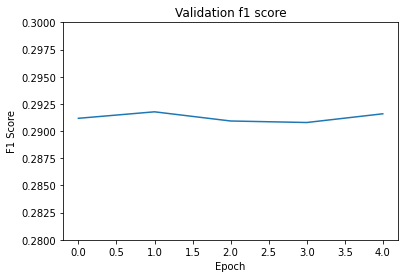

In [ ]:
losses = [4.51385025, 4.510868629, 4.50967360, 4.50880838, 4.5084543]
f1_scores = [0.291175, 0.291772, 0.290928, 0.290788, 0.291590]

fig, ax = plt.subplots()
sns.lineplot(data = f1_scores, ax=ax).set(title="Validation f1 score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
ax.set_ylim(0.28,0.3)
plt.show(fig)

In [ ]:
from sklearn.metrics import classification_report
# print metrics after final epoch

In [ ]:
# plot losses
epoch_losses = [x.cpu().item() for x in skipgram_model.test_losses]

print(epoch_losses)

plt.figure(figsize=(20, 8))
fig = sns.lineplot(data = epoch_losses).set(title="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show(fig)

print(skipgram_model.train_losses)

In [ ]:
test_input = next(iter(train_dataloader))[0]
skipgram_model(test_input.to("cuda"))

**Baseline model for comparison, using naive one-hot encoding representation for ingredients.**

In [ ]:
# query input: user id (+ ratings)
# prediction:  rating of other recipes
# Create model
device = "cpu"

# Define model
class RatingModel(nn.Module):
    # Your code
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8*2*batch_size, 32),  # 2 vector size 8 input (user, nutrition)
            nn.ReLU(),  # Important between linear layers
            nn.Linear(32, 32),  # Multiple stacked layers
            nn.ReLU(),  
            nn.Linear(32, batch_size) # output = 1 dimension, rating between 0 and 5
        )

    def forward(self, user, recipe):
        query = torch.flatten(query)
        doc = torch.flatten(doc)
        tensor = torch.cat((query,doc),0)
        logits = self.linear_relu_stack(tensor)
        return logits

model = RatingModel().to(device)
model.double()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) #todo
loss_fn = nn.CrossEntropyLoss() #good for classification (might as well consider mean squared error for continues rating prediction at interval [0-5])

In [ ]:
# Implement data loaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=batch_size)
print(train_data[0])

# for x, y in train_dataloader:
#     print(f"Shape of x: {x.shape} {x.dtype}")
#     print(f"Shape of x: {y.shape} {y.dtype}")
#     break

# 2) Generation of natural language meal preperation (reference preperation + meal) - input ingredient + recipe name